In [1]:
#Setup and Configuration
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import os
import time

# --- Configuration ---
DATA_DIR = './data'  

# Define the image size 
INPUT_SIZE = 224  

# Number of classes (Mug, Bottle, Book, Stapler, etc.)
NUM_CLASSES = 10  

# Batch size for loading data
BATCH_SIZE = 16

# Number of training epochs (can be adjusted after initial run)
NUM_EPOCHS = 50  

# Check for GPU (CUDA) availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [2]:
# Cell 2: Data Augmentation and Loaders

# Define transformations for the training set (includes augmentation)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(INPUT_SIZE),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(),        # Randomly flip the image
    transforms.ToTensor(),                    # Convert to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize for pre-trained ImageNet models
])

# Define transformations for validation and test sets (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets from folders (ImageFolder automatically handles labeling)
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), train_transforms),
    'val': datasets.ImageFolder(os.path.join(DATA_DIR, 'validation'), val_test_transforms),
    'test': datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), val_test_transforms)
}

# Create DataLoaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True if x == 'train' else False, num_workers=4)
    for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes # List of your 10 office items

print(f"Classes found: {class_names}")
print(f"Training images: {dataset_sizes['train']}, Validation images: {dataset_sizes['val']}, Test images: {dataset_sizes['test']}")

Classes found: ['Book', 'Bottle', 'Calculator', 'File_Folder', 'Keyboard', 'Mouse', 'Mug', 'Pen_Pencil', 'Stapler', 'Tape_Dispenser']
Training images: 704, Validation images: 186, Test images: 183


In [3]:
# --- 1. Load Pre-trained Model ---
# We start with the pre-trained weights to leverage prior knowledge.
model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# --- 2. Freeze Initial Layers ---
# Freeze all parameters initially to protect the core feature knowledge.
for param in model_ft.parameters():
    param.requires_grad = False

# --- 3. UNFREEZE the Last Convolutional Block (layer4) ---
# This block holds the highest-level feature maps before the classifier.
# Unfreezing it allows for fine-tuning its weights on the office data.
for param in model_ft.layer4.parameters():
    param.requires_grad = True

# --- 4. Replace and Unfreeze the Final Classifier Head (model.fc) ---
# This is the new, custom layer for your 10 office classes.
num_ftrs = model_ft.fc.in_features 
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Explicitly ensure the new fc layer is trainable (though it should be by default)
for param in model_ft.fc.parameters():
    param.requires_grad = True

# --- 5. Move Model to Device (GPU) ---
model_ft = model_ft.to(device)

# --- 6. Define Loss Function and Optimizer ---

# CrossEntropyLoss is standard for classification.
criterion = nn.CrossEntropyLoss()

# The optimizer MUST target ONLY the parameters where requires_grad is True.
# We use filter() to select the trainable parameters (layer4 and fc).
# Using SGD is often preferred for fine-tuning as it makes smaller, stable adjustments.
optimizer_ft = optim.SGD(
    filter(lambda p: p.requires_grad, model_ft.parameters()), 
    lr=0.001, 
    momentum=0.9  # Momentum often stabilizes training
)

print("Model setup complete: ResNet-50 loaded, layer4 and fc are unfrozen and ready for fine-tuning.")

Model setup complete: ResNet-50 loaded, layer4 and fc are unfrozen and ready for fine-tuning.


In [4]:
# Cell 4: Training Function and Execution

def train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass: track gradients only in train phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # Save the model checkpoint
                torch.save(model.state_dict(), 'best_model_weights.pth')
                print("Model weights saved!")
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# --- Execute Training ---
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=NUM_EPOCHS)

Epoch 0/49
----------
train Loss: 2.1716 Acc: 0.3111
val Loss: 1.9412 Acc: 0.6183
Model weights saved!

Epoch 1/49
----------
train Loss: 1.7616 Acc: 0.6818
val Loss: 1.4632 Acc: 0.7581
Model weights saved!

Epoch 2/49
----------
train Loss: 1.3300 Acc: 0.7557
val Loss: 1.0424 Acc: 0.7957
Model weights saved!

Epoch 3/49
----------
train Loss: 1.0459 Acc: 0.7685
val Loss: 0.7774 Acc: 0.7903

Epoch 4/49
----------
train Loss: 0.8586 Acc: 0.7983
val Loss: 0.6467 Acc: 0.8172
Model weights saved!

Epoch 5/49
----------
train Loss: 0.7265 Acc: 0.8011
val Loss: 0.5774 Acc: 0.8333
Model weights saved!

Epoch 6/49
----------
train Loss: 0.6827 Acc: 0.8111
val Loss: 0.5309 Acc: 0.8495
Model weights saved!

Epoch 7/49
----------
train Loss: 0.6222 Acc: 0.8295
val Loss: 0.5126 Acc: 0.8387

Epoch 8/49
----------
train Loss: 0.5662 Acc: 0.8466
val Loss: 0.4877 Acc: 0.8387

Epoch 9/49
----------
train Loss: 0.5175 Acc: 0.8565
val Loss: 0.4726 Acc: 0.8333

Epoch 10/49
----------
train Loss: 0.5043 Ac

Test Accuracy: 84.15%
Macro F1-Score: 0.8033


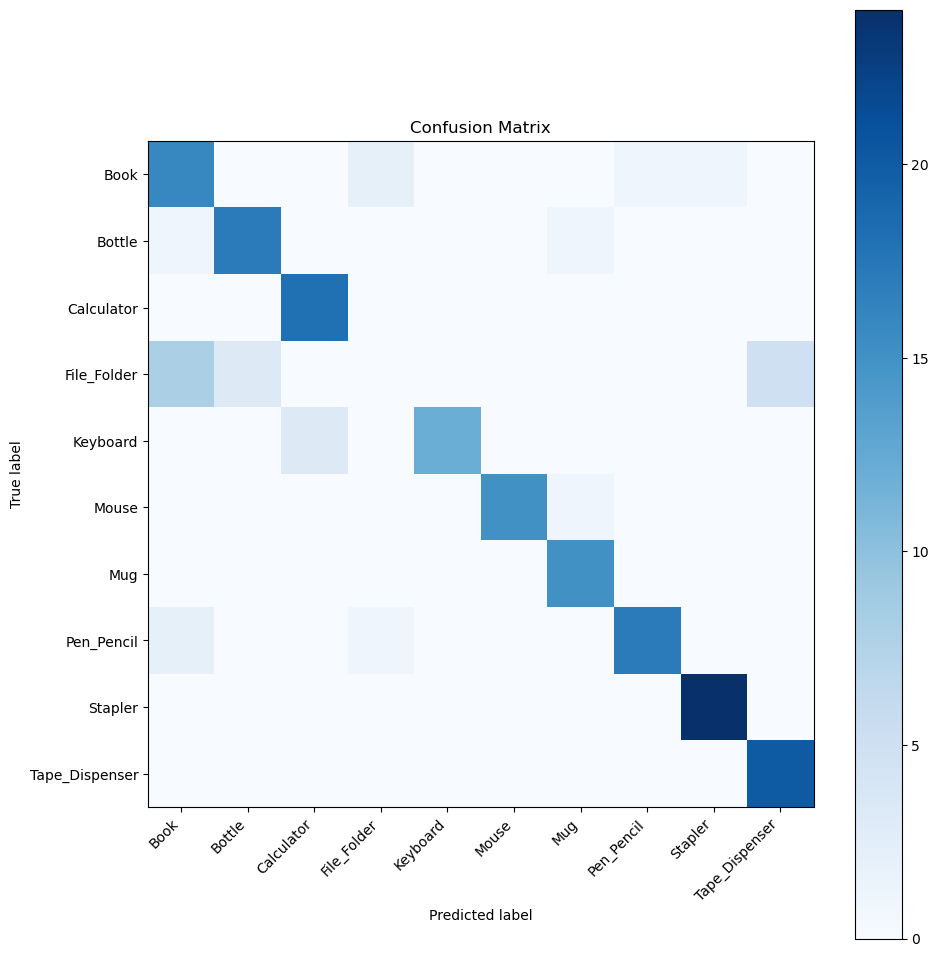

In [5]:
# Cell 5: Evaluation and Metrics on Test Set

# Set model to evaluation mode
model_ft.eval()

all_preds = []
all_labels = []

# Use the test DataLoader
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Calculate Required Metrics ---
# 1. Overall Accuracy
test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# 2. Macro F1-Score
macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Macro F1-Score: {macro_f1:.4f}")

# Save the metrics to a file (for the final submission)
with open('evaluation_metrics.txt', 'w') as f:
    f.write(f"Test Accuracy: {test_accuracy*100:.2f}%\n")
    f.write(f"Macro F1-Score: {macro_f1:.4f}\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(all_labels, all_preds, target_names=class_names))


# 3. Confusion Matrix Visualization
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix.png') # Save the plot as an image
plt.show()
